## 선별 개별 종목에 대한 알맞은 비율 구성법

### 개별 종목 머지(merge)

In [1]:
import pandas as pd
from pykrx import stock

In [ ]:
start_date = '20200101'
end_date = '20211231'
symbols = ['035420','196170','042700','005930'] # Naver, 알트로젠, 한미반도체, 삼성전자


In [3]:
# concate DataFrames 
df_stock = pd.DataFrame()
for symbol in symbols:
    df_stock[symbol] = stock.get_market_ohlcv_by_date(start_date, end_date, symbol)['종가'] # 네이버

df_stock


,035420,196170,042700,005930
날짜,,,,
2020-01-02,182500,19413,3980,55200
2020-01-03,181500,18746,3985,55500
2020-01-06,180500,17494,3920,55500
2020-01-07,187000,17995,3925,55800
2020-01-08,183000,16883,3925,56800
...,...,...,...,...
2021-12-24,384000,58389,18050,80500
2021-12-27,380500,59807,18300,80200
2021-12-28,384500,62809,18425,80300


In [4]:
#데일리 수익률
daily_return = df_stock.pct_change(periods = 1) # pct_change 는 shift 와 mean 을 한번에
daily_return

,035420,196170,042700,005930
날짜,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.005479,-0.034358,0.001256,0.005435
2020-01-06,-0.005510,-0.066788,-0.016311,0.000000
2020-01-07,0.036011,0.028638,0.001276,0.005405
2020-01-08,-0.021390,-0.061795,0.000000,0.017921
...,...,...,...,...
2021-12-24,0.015873,-0.014082,0.000000,0.007509
2021-12-27,-0.009115,0.024285,0.013850,-0.003727
2021-12-28,0.010512,0.050195,0.006831,0.001247


In [5]:
# 리스크 점수 구하기
annual_return = daily_return.mean() * 252
annual_return

035420    0.437258
196170    0.883705
042700    0.946450
005930    0.217409
dtype: float64

In [6]:
# 공분산
daily_cov = daily_return.cov()
daily_cov

,035420,196170,042700,005930
035420,0.000526,0.000409,0.000260,0.000159
196170,0.000409,0.002319,0.000473,0.000185
042700,0.000260,0.000473,0.001220,0.000283
005930,0.000159,0.000185,0.000283,0.000315


In [ ]:
annual_cov = daily_cov * 252
annual_cov

# .cov()는 공분산을 계산하는 함수입니다. 공분산은 두 개 이상의 변수 간의 관계를 측정하는 지표로, 두 데이터가 함께 얼마나 움직이는지 나타냅니다.

# 공분산이 양수이면 두 데이터가 같은 방향으로 움직이는 경향이 있다는 의미입니다.
# 공분산이 음수이면 두 데이터가 반대 방향으로 움직이는 경향이 있다는 의미입니다.
# 공분산이 0에 가까우면 두 데이터 간에 상관관계가 없다는 뜻입니다.

,035420,196170,042700,005930
035420,0.132514,0.102990,0.065583,0.039966
196170,0.102990,0.584310,0.119117,0.046511
042700,0.065583,0.119117,0.307320,0.071432
005930,0.039966,0.046511,0.071432,0.079495


### 비율 생성과 정규화

In [ ]:
import numpy as np

weights = np.random.random(len(symbols)) #비율 랜덤생성 #gpt 한테 물어보기
# weights, type(weights), weights.shape
weights = weights / np.sum(weights) # 정규화
weights, type(weights), np.sum(weights)

# 주식의 비율(weight)을 랜덤하게 생성하고, 그 합이 1이 되도록 **정규화(normalize)**하는 작업


(array([0.1516995 , 0.22170693, 0.27177752, 0.35481605]),
 numpy.ndarray,
 0.9999999999999999)

In [ ]:
returnofrate = np.dot(weights, annual_return)
# returns, type(returns)
risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # sqrt = 루트
risk, type(risk)

# annual_cov: 각 주식의 공분산 행렬 (서로 얼마나 같이 움직이는지를 나타냄)

# np.dot(annual_cov, weights):
# 공분산 행렬과 투자 비율을 곱해서 각 주식이 포트폴리오 리스크에 미치는 영향을 계산.

# np.dot(weights.T, np.dot(annual_cov, weights)):
# 위 결과에 다시 weights.T를 곱해서 **전체 포트폴리오 리스크(분산)**를 계산.

# np.sqrt(...):
# 분산(variance)의 **제곱근(sqrt)을 계산하면 표준편차(standard deviation)**가 됩니다.
# **표준편차 = 리스크(Risk)**이므로, 이 값이 **포트폴리오의 전체 변동성(위험도)**가 됩니다.

(0.34141602238246116, numpy.float64)

In [17]:
np.dot(annual_cov, weights)

array([0.07494028, 0.1940453 , 0.14522583, 0.06399428])

In [18]:
np.dot(weights.T, np.dot(annual_cov, weights))

0.11656490033946121

In [21]:
# 여러 포트폴리오 비율 적용

portfolio_returnofrate = list()
portfolio_risks = list()
portfolio_weights = list()

for number in range(200):
    weights = np.random.random(len(symbols)) #비율 랜덤생성 #gpt 한테 물어보기
    weights = weights / np.sum(weights) # 정규화
    returnofrate = np.dot(weights, annual_return)
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # sqrt = 루트
    
    portfolio_weights.append(weights)
    portfolio_returnofrate.append(returnofrate)
    portfolio_risks.append(risk)

In [23]:
# Convert DataFrame : Return of rate, Risk, weights
portfolio = {
            "ReturnOfRate" : portfolio_returnofrate
             , "Risk" : portfolio_risks
             }

for idx, symbol in enumerate(symbols):
    portfolio[symbol] = [weight[idx] for weight in portfolio_weights]
    pass

df_portfolio = pd.DataFrame(portfolio)
df_portfolio.head(3)

,ReturnOfRate,Risk,035420,196170,042700,005930
0,0.609657,0.338745,0.157910,0.139916,0.362539,0.339635
1,0.524812,0.310057,0.521828,0.090652,0.181442,0.206079
2,0.643444,0.350867,0.464773,0.155176,0.302400,0.077650


In [24]:
df_portfolio[['ReturnOfRate', 'Risk']]

,ReturnOfRate,Risk
0,0.609657,0.338745
1,0.524812,0.310057
2,0.643444,0.350867
3,0.713230,0.431850
4,0.679938,0.449083
...,...,...
195,0.717823,0.407722
196,0.803970,0.479633
197,0.511251,0.328963
198,0.444289,0.297531


In [25]:
df_portfolio[['035420','196170','042700','005930']]

,035420,196170,042700,005930
0,0.157910,0.139916,0.362539,0.339635
1,0.521828,0.090652,0.181442,0.206079
2,0.464773,0.155176,0.302400,0.077650
3,0.288786,0.411161,0.217240,0.082813
4,0.077325,0.484641,0.168186,0.269847
...,...,...,...,...
195,0.081033,0.328559,0.361682,0.228725
196,0.054142,0.471149,0.357638,0.117071
197,0.138425,0.263695,0.120309,0.477570
198,0.439465,0.154589,0.037394,0.368552


### Charts 작성

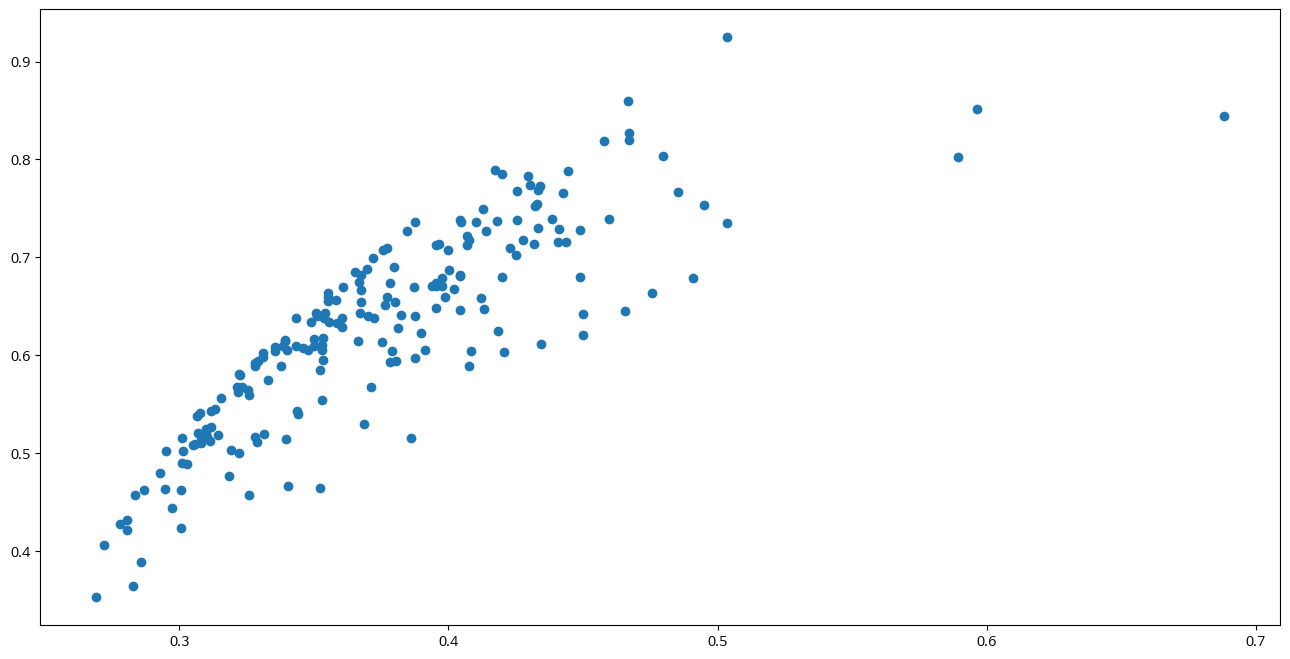

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.scatter(x=df_portfolio['Risk'], y=df_portfolio['ReturnOfRate'])

plt.show()